In [1]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt
import polars as pl
import astartes as at
import mlflow

In [2]:
from scipy.signal import savgol_filter
 
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

In [3]:
# Read in the data
# url = 'https://raw.githubusercontent.com/nevernervous78/nirpyresearch/master/data/peach_spectra_brix.csv'
# data = pl.read_csv(url)

In [4]:
# data

In [5]:
# y = data['Brix']
# X = data.drop("Brix")


In [6]:
# X_example = X.to_numpy().flatten()
# X_example
# plt.plot(X.T)
# plt.show()

In [7]:
# wl = np.arange(1100,2300,2) #wavelength
# wl

In [8]:
# X2 = savgol_filter(X, 17, polyorder = 5, deriv=2)
# X2
# print(X.shape)
# print(X2.shape)

In [9]:
# plt.plot(wl, X2.T)
# plt.show()

In [12]:
# Read in raw NIR data for IBF samples
ibf_spectra = pl.read_csv("IBF spectra all_old.csv")
ibf_spectra.head()

Sample Name,Device Id,3921.568654,3935.185205,3948.801756,3962.418307,3976.034857,3989.651408,4003.267959,4016.884509,4030.50106,4044.117611,4057.734162,4071.350712,4084.967263,4098.583814,4112.200364,4125.816915,4139.433466,4153.050017,4166.666567,4180.283118,4193.899669,4207.516219,4221.13277,4234.749321,4248.365872,4261.982422,4275.598973,4289.215524,4302.832074,4316.448625,4330.065176,4343.681727,4357.298277,4370.914828,4384.531379,…,6917.209812,6930.826362,6944.442913,6958.059464,6971.676014,6985.292565,6998.909116,7012.525667,7026.142217,7039.758768,7053.375319,7066.991869,7080.60842,7094.224971,7107.841522,7121.458072,7135.074623,7148.691174,7162.307724,7175.924275,7189.540826,7203.157376,7216.773927,7230.390478,7244.007029,7257.623579,7271.24013,7284.856681,7298.473231,7312.089782,7325.706333,7339.322884,7352.939434,7366.555985,7380.172536,7393.789086,7407.405637
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""LMP-406_2""","""NeoScanner_23010031""",48.845921,48.401282,48.032263,47.738447,47.521671,47.398642,47.42378,47.653012,48.148185,48.948272,50.046691,51.381578,52.845843,54.313639,55.670062,56.831118,57.744913,58.390245,58.799043,59.0061,59.055248,58.992922,58.864336,58.71217,58.577023,58.497532,58.507506,58.635899,58.884,59.230586,59.644633,60.095461,60.568994,61.080658,61.677915,…,76.771973,77.068295,77.408519,77.757899,78.111159,78.497619,78.968385,79.583636,80.352592,81.252759,82.234191,83.238226,84.217363,85.146974,86.023187,86.851452,87.628257,88.339288,88.96513,89.489179,89.912303,90.255693,90.552962,90.834943,91.1152,91.382132,91.60116,91.747552,91.818082,91.840548,91.866407,91.95143,92.131815,92.405098,92.726154,93.015502,93.209764
"""LMP-406_1""","""NeoScanner_23010031""",48.990801,48.477955,48.034054,47.680215,47.431252,47.30371,47.340629,47.580447,48.074469,48.859796,49.936092,51.251702,52.708055,54.181812,55.553759,56.731717,57.656259,58.303462,58.709686,58.916857,58.974998,58.932587,58.83154,58.707415,58.592998,58.521553,58.526116,58.639565,58.871189,59.206799,59.619234,60.077771,60.564908,61.090763,61.69754,…,77.225275,77.373023,77.543442,77.775163,78.111212,78.582836,79.197564,79.942934,80.772543,81.651314,82.556807,83.48071,84.421706,85.373729,86.31615,87.212627,88.012828,88.682162,89.219617,89.64681,90.003548,90.33134,90.656891,90.982706,91.288968,91.543735,91.717793,91.817371,91.868962,91.914978,91.998418,92.147651,92.366662,92.633122,92.9062,93.13659,93.302278
"""LMP-172_2""","""NeoScanner_23010031""",49.876259,49.455092,49.093952,48.790917,48.551411,48.398664,48.39412,48.599043,49.07836,49.873322,50.978912,52.333073,53.82558,55.324746,56.709072,57.889808,58.813897,59.463739,59.878377,60.098871,60.171917,60.141776,60.04745,59.924656,59.810212,59.744654,59.768715,59.919852,60.20155,60.584507,61.021852,61.465074,61.888635,62.309912,62.793934,…,77.276933,77.473948,77.709813,77.98699,78.322919,78.74437,79.274672,79.928644,80.682922,81.510893,82.389047,83.306047,84.26231,85.258773,86.280172,87.284995,88.200939,88.958666,89.531281,89.933558,90.221746,90.468851,90.732973,91.034329,91.352071,91.63976,91.852544,91.992876,92.09626,92.214767,92.388155,92.621519,92.881742,93.11483,93.275293,93.349254,93.384201
"""LMP-172_1""","""NeoScanner_23010031""",50.084559,49.56703,49.111851,48.743245,48.480329,48.341666,48.36873,48.596709,49.07604,49.847224,50.9167,52.239185,53.717627,55.22359,56.628422,57.830862,58.766968,59.415824,59.823474,60.041087,60.123064,60.114533,60.047874,59.948181,59.843146,59.770229,59.774855,59.905359,60.17688,60.565086,61.020625,61.48683,61.928535,62.356489,62.834851,…,77.472972,77.717062,77.991689,78.288017,78.624202,79.039344,79.573612,80.254929,81.054964,81.931851,82.843526,83.766326,84.700349,85.656989,86.635591,87.604679,88.492429,89.

In [13]:
# Filter function to get rid of low quality spectra
def filter_spectra(X: np.ndarray, threshold: int) -> np.ndarray:
    """
    Takes a Numpy array and filters out any spectra with low spread between the minimum and maximum value of the spectra
    Returns a filtered Numpy array of spectra
    """
    spread = X.max(axis=1) - X.min(axis=1)
    idx = spread > threshold

    return X[idx], idx

# Split spectral data from the names
ibf_X = ibf_spectra.drop(("Sample Name", "Device Id")).to_numpy()
ibf_names = ibf_spectra["Sample Name"]

In [14]:
# Filter spectra based on a low spread and subset the X_spectra and names data
ibf_X, clean_spectra_idx = filter_spectra(ibf_X, 10)
ibf_names = ibf_names.to_numpy()[idx]

NameError: name 'idx' is not defined

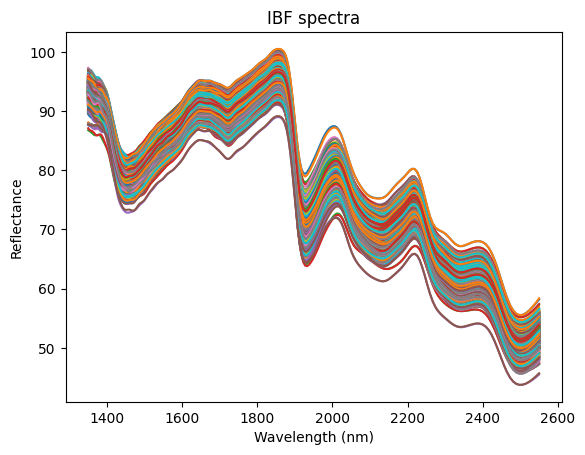

In [15]:
# Get the spectra wavelengths (nm) from the wavenumber (cm-1) and reverse to have increasing wavelength
wavenum = ibf_spectra.drop(("Sample Name", "Device Id")).columns

# Convert to wavelengths (nm) and reverse to have increasing wavelength
lambda_nm = map(lambda x: 10**7/float(x), wavenum)
lambda_nm = np.round(list(lambda_nm), 1)[::-1]

# Reverse the order of spectra to fit with the wavelengths
ibf_X = ibf_X[:,::-1]

plt.plot(lambda_nm, ibf_X.T)
plt.title("IBF spectra")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.show()

# New column names if needed
new_cols = [f"X_{i}" for i in range(len(lambda_nm))]

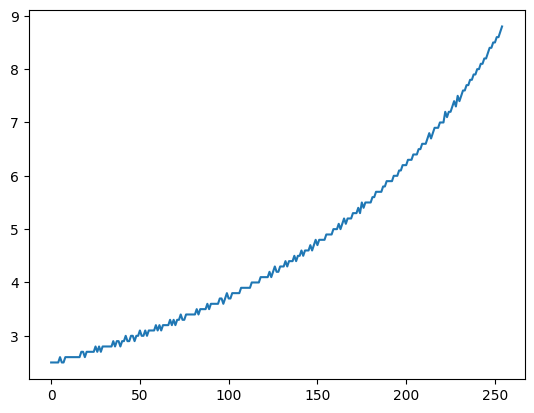

In [16]:
# Interval between the wavelengths is not uniform
LAG = 1
lag_1_nm = np.roll(lambda_nm, LAG)
diff = lambda_nm[LAG:-LAG] - lag_1_nm[LAG:-LAG]

plt.plot(diff)
plt.show()

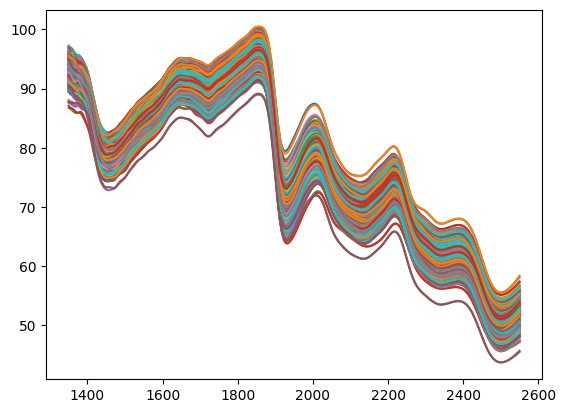

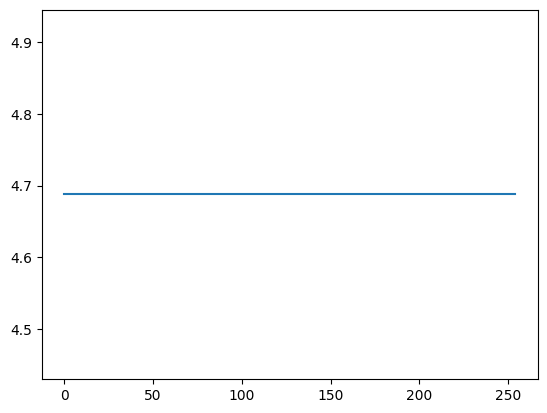

In [17]:
# Reinterpolate to enforce equal interval wavelengths
lambda_equal_nm = np.linspace(
    start=lambda_nm.min(),
    stop=lambda_nm.max(),
    num=257
)

# Assert the same number of wavelengths
assert(len(lambda_equal_nm) == len(lambda_nm))

# Create empy array to hold resampled spectra
ibf_X_interp = np.empty(ibf_X.shape)

# Resampling loop
for i, x in enumerate(ibf_X):
    new_x = np.interp(
        x=lambda_equal_nm, 
        xp=lambda_nm, 
        fp=x
    )

    ibf_X_interp[i] = new_x

# Plot out resampled spectra
plt.plot(lambda_equal_nm, ibf_X_interp.T)
plt.show()

# Plot lag intervals to show equal spectral spacing
lag_1_nm = np.roll(lambda_equal_nm, LAG)
diff = lambda_equal_nm[LAG:-LAG] - lag_1_nm[LAG:-LAG]
plt.plot(diff)
plt.show()

In [56]:
# Savitsky-Golay filtering for IBF spectra

ibf_X_sg = savgol_filter(ibf_X_interp, 17, polyorder = 3, deriv=2)

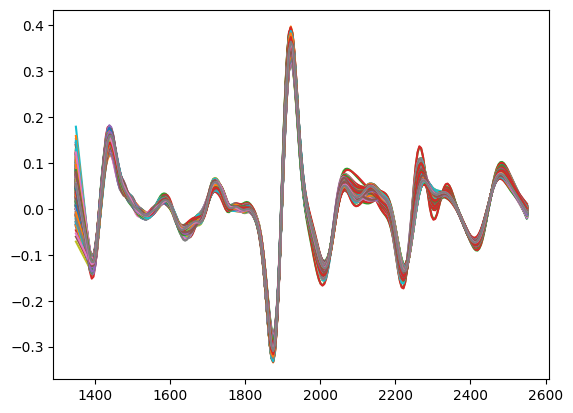

In [57]:
plt.plot(lambda_equal_nm, ibf_X_sg.T)
plt.show()

In [20]:
# Kennard stone selection for the training set

# Merge spectra onto calibration set filenames
# Read in Excel file of calibration GT
calib_y = pl.read_excel("TLI_PLP_2024-08-12.xlsx", sheet_name="TLI_PLP_2024-08-12")
calib_y

Could not determine dtype for column 4, falling back to string


Description1,Test_Mode,Moisture,Dry_Matter,pH,CP,ADF,aNDF,aNDFom,NFC,TDN_ADF,NEL3x_ADF,NEG_ADF,NEM_ADF,RFV,RDM,California_TDN_90%dry
str,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""LMP_479""","""C""",9.87,90.13,null,14.2,41.7,48.06,46.23,28.5,56.42,57.45,30.34,56.07,109.34,90.13,45.94
"""LMP_246""","""C""",10.85,89.15,null,16.04,35.21,39.53,37.95,35.21,61.47,63.08,34.69,60.83,144.86,89.15,50.33
"""LMP_256""","""C""",10.84,89.16,null,12.34,40.78,44.4,43.09,33.22,57.13,58.24,31.31,57.13,119.57,89.16,46.56
"""LMP_150""","""C""",10.76,89.24,null,11.43,43.87,49.74,48.74,28.34,54.73,55.57,28.7,54.27,102.25,89.24,44.47
"""LMP_225""","""C""",10.91,89.09,null,14.14,39.78,44.34,42.61,32.17,57.91,59.11,31.94,57.81,121.66,89.09,47.24
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""406_TLI C5""","""C""",7.51,92.49,null,10.58,44.58,67.86,65.18,13.62,54.17,54.95,23.74,48.9,74.33,99.2,43.99
"""408_Rush""","""C""",7.16,92.84,null,12.04,45.18,65.26,62.99,14.57,53.7,54.42,25.28,50.56,76.6,99.68,43.58
"""201_MN Clearwater""","""C""",7.68,92.32,null,10.22,43.39,66.18,65.02,14.09,55.1,55.98,24.28,49.49,77.31,98.82,44.8


In [21]:
len(ibf_names)

590

In [22]:
len(ibf_X_sg)

588

In [23]:
# Work on SKlearn Pipeline
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler

class SavgolTransform(BaseEstimator):
    """
    Implement a Savitsky Golay filter as a preprocessing step
    Returns the filtered, derivitasized data
    """    
    def __init__(self, window_length: int=10, polyorder: int=5, deriv: int=2):
        """ Initialize and allow keyword arguments to be passed """
        self.window_length=window_length
        self.polyorder = polyorder
        self.deriv = deriv

    def fit(self, X=None, y=None):
        """ Not implemented, return self """
        return self

    def transform(self, X):
        """ Transform the X matrix of spectra with a Savgol filter according to initialized attributes """
        X_filtered = savgol_filter(
            x=X,
            window_length=self.window_length,
            polyorder=self.polyorder,
            deriv=self.deriv
        )
        return X_filtered

        

In [24]:
X = np.random.randn(400, 400)
y = np.random.randn(400)

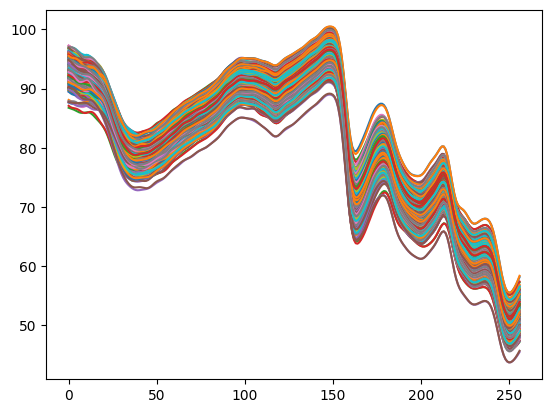

In [25]:
plt.plot(ibf_X.T)
plt.show()

In [26]:
pipe = Pipeline([
    ('savgol', SavgolTransform()),
    ('scaler', StandardScaler()),
])

pipe.set_params(
    savgol__window_length=17,
    savgol__polyorder=3,
    savgol__deriv=2,
    scaler__with_std=False
)

fit_transformed = pipe.fit_transform(ibf_X)

transformed = pipe.transform(ibf_X)

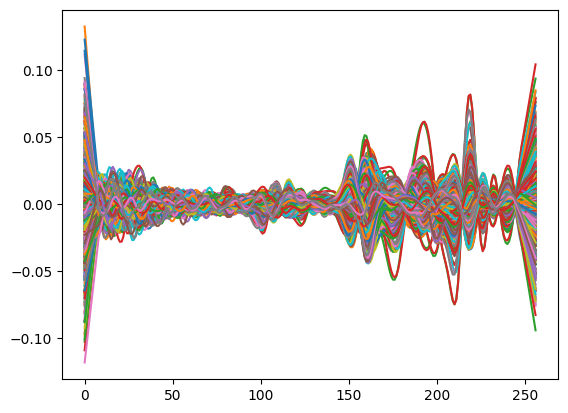

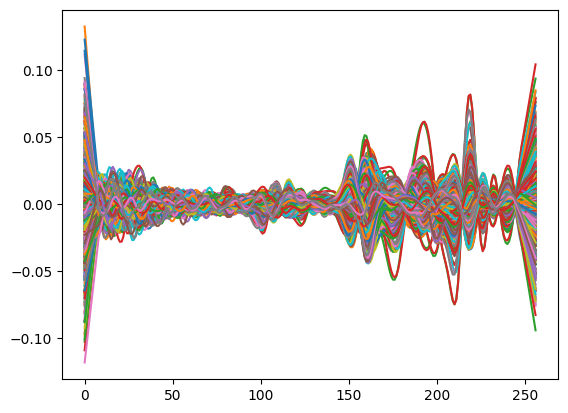

In [27]:
transformed.shape

plt.plot(transformed.T)
plt.show()

plt.plot(fit_transformed.T)
plt.show()
plt.close()

In [28]:
# Kennard Stone algorithm
import astartes as at
X_train, X_test, y_train, y_test = at.train_test_split(X, y, train_size=0.70)

In [29]:
scaler = StandardScaler(with_std=False)

In [30]:
print(calib_y['Description1'])

shape: (83,)
Series: 'Description1' [str]
[
	"LMP_479"
	"LMP_246"
	"LMP_256"
	"LMP_150"
	"LMP_225"
	…
	"406_TLI C5"
	"408_Rush"
	"201_MN Clearwater"
	"304_TLI 704"
	"410_TLI 703"
]


In [31]:
idx


NameError: name 'idx' is not defined

In [32]:
len(idx)
len(ibf_spectra)

NameError: name 'idx' is not defined

In [33]:
sample_names = ibf_spectra\
    .select(
        pl.col('Sample Name')\
        .str\
        .split('_')\
        .list.to_struct("max_width", ["sample_name", "rep"])
    ).unnest('Sample Name')

full_df = pl.concat([sample_names, ibf_spectra], how='horizontal')\
    .drop(('Sample Name', 'Device Id'))\
    .filter(clean_spectra_idx)

In [34]:
full_df

sample_name,rep,3921.568654,3935.185205,3948.801756,3962.418307,3976.034857,3989.651408,4003.267959,4016.884509,4030.50106,4044.117611,4057.734162,4071.350712,4084.967263,4098.583814,4112.200364,4125.816915,4139.433466,4153.050017,4166.666567,4180.283118,4193.899669,4207.516219,4221.13277,4234.749321,4248.365872,4261.982422,4275.598973,4289.215524,4302.832074,4316.448625,4330.065176,4343.681727,4357.298277,4370.914828,4384.531379,…,6917.209812,6930.826362,6944.442913,6958.059464,6971.676014,6985.292565,6998.909116,7012.525667,7026.142217,7039.758768,7053.375319,7066.991869,7080.60842,7094.224971,7107.841522,7121.458072,7135.074623,7148.691174,7162.307724,7175.924275,7189.540826,7203.157376,7216.773927,7230.390478,7244.007029,7257.623579,7271.24013,7284.856681,7298.473231,7312.089782,7325.706333,7339.322884,7352.939434,7366.555985,7380.172536,7393.789086,7407.405637
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""LMP-406""","""2""",48.845921,48.401282,48.032263,47.738447,47.521671,47.398642,47.42378,47.653012,48.148185,48.948272,50.046691,51.381578,52.845843,54.313639,55.670062,56.831118,57.744913,58.390245,58.799043,59.0061,59.055248,58.992922,58.864336,58.71217,58.577023,58.497532,58.507506,58.635899,58.884,59.230586,59.644633,60.095461,60.568994,61.080658,61.677915,…,76.771973,77.068295,77.408519,77.757899,78.111159,78.497619,78.968385,79.583636,80.352592,81.252759,82.234191,83.238226,84.217363,85.146974,86.023187,86.851452,87.628257,88.339288,88.96513,89.489179,89.912303,90.255693,90.552962,90.834943,91.1152,91.382132,91.60116,91.747552,91.818082,91.840548,91.866407,91.95143,92.131815,92.405098,92.726154,93.015502,93.209764
"""LMP-406""","""1""",48.990801,48.477955,48.034054,47.680215,47.431252,47.30371,47.340629,47.580447,48.074469,48.859796,49.936092,51.251702,52.708055,54.181812,55.553759,56.731717,57.656259,58.303462,58.709686,58.916857,58.974998,58.932587,58.83154,58.707415,58.592998,58.521553,58.526116,58.639565,58.871189,59.206799,59.619234,60.077771,60.564908,61.090763,61.69754,…,77.225275,77.373023,77.543442,77.775163,78.111212,78.582836,79.197564,79.942934,80.772543,81.651314,82.556807,83.48071,84.421706,85.373729,86.31615,87.212627,88.012828,88.682162,89.219617,89.64681,90.003548,90.33134,90.656891,90.982706,91.288968,91.543735,91.717793,91.817371,91.868962,91.914978,91.998418,92.147651,92.366662,92.633122,92.9062,93.13659,93.302278
"""LMP-172""","""2""",49.876259,49.455092,49.093952,48.790917,48.551411,48.398664,48.39412,48.599043,49.07836,49.873322,50.978912,52.333073,53.82558,55.324746,56.709072,57.889808,58.813897,59.463739,59.878377,60.098871,60.171917,60.141776,60.04745,59.924656,59.810212,59.744654,59.768715,59.919852,60.20155,60.584507,61.021852,61.465074,61.888635,62.309912,62.793934,…,77.276933,77.473948,77.709813,77.98699,78.322919,78.74437,79.274672,79.928644,80.682922,81.510893,82.389047,83.306047,84.26231,85.258773,86.280172,87.284995,88.200939,88.958666,89.531281,89.933558,90.221746,90.468851,90.732973,91.034329,91.352071,91.63976,91.852544,91.992876,92.09626,92.214767,92.388155,92.621519,92.881742,93.11483,93.275293,93.349254,93.384201
"""LMP-172""","""1""",50.084559,49.56703,49.111851,48.743245,48.480329,48.341666,48.36873,48.596709,49.07604,49.847224,50.9167,52.239185,53.717627,55.22359,56.628422,57.830862,58.766968,59.415824,59.823474,60.041087,60.123064,60.114533,60.047874,59.948181,59.843146,59.770229,59.774855,59.905359,60.17688,60.565086,61.020625,61.48683,61.928535,62.356489,62.834851,…,77.472972,77.717062,77.991689,78.288017,78.624202,79.039344,79.573612,80.254929,81.054964,81.931851,82.843526,83.766326,84.700349,85.656989,86.635591,87.604679,88.492429,89.220596,89.754344,90.10892,90.350737,90.567833,90.829544,91.155909,91.51227,91.829598,9

In [35]:
calib_y = pl.read_excel("TLI_PLP_2024-08-12.xlsx", sheet_name="TLI_PLP_2024-08-12")
calib_y = calib_y.rename({"Description1": "sample_name"})\
    .with_columns(pl.col('sample_name')\
        .str\
        .replace("_", "-"))\
    .drop(('pH', 'Test_Mode'))

calib_y

Could not determine dtype for column 4, falling back to string


sample_name,Moisture,Dry_Matter,CP,ADF,aNDF,aNDFom,NFC,TDN_ADF,NEL3x_ADF,NEG_ADF,NEM_ADF,RFV,RDM,California_TDN_90%dry
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""LMP-479""",9.87,90.13,14.2,41.7,48.06,46.23,28.5,56.42,57.45,30.34,56.07,109.34,90.13,45.94
"""LMP-246""",10.85,89.15,16.04,35.21,39.53,37.95,35.21,61.47,63.08,34.69,60.83,144.86,89.15,50.33
"""LMP-256""",10.84,89.16,12.34,40.78,44.4,43.09,33.22,57.13,58.24,31.31,57.13,119.57,89.16,46.56
"""LMP-150""",10.76,89.24,11.43,43.87,49.74,48.74,28.34,54.73,55.57,28.7,54.27,102.25,89.24,44.47
"""LMP-225""",10.91,89.09,14.14,39.78,44.34,42.61,32.17,57.91,59.11,31.94,57.81,121.66,89.09,47.24
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""406-TLI C5""",7.51,92.49,10.58,44.58,67.86,65.18,13.62,54.17,54.95,23.74,48.9,74.33,99.2,43.99
"""408-Rush""",7.16,92.84,12.04,45.18,65.26,62.99,14.57,53.7,54.42,25.28,50.56,76.6,99.68,43.58
"""201-MN Clearwater""",7.68,92.32,10.22,43.39,66.18,65.02,14.09,55.1,55.98,24.28,49.49,77.31,98.82,44.8


In [36]:
calibration_data = calib_y\
    .join(full_df, on='sample_name', how='inner')

In [37]:
calibration_data.shape

(68, 273)

In [38]:
# Get non-calibration samples

inner_samples = calib_y\
    .join(full_df, on='sample_name', how='inner')

non_calib = full_df\
    .join(inner_samples, on='sample_name', how='anti')

non_calib.shape

(520, 259)

In [39]:
y_train[:, 0]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [40]:
# Split the calibration data into X and Y
wc_X = non_calib[:, "3921.568654":"7407.405637"].to_numpy()
wc_Y = non_calib[:, "sample_name":"rep"]\
    .cast({'rep': pl.UInt8})

# Get new wet chem samples
wc_sample = 40 # we want to send 40 samples
train_size = 40 / non_calib.shape[0]

wc_train, wc_test, wc_y_train, wc_y_test = at.train_test_split(wc_X, wc_Y, train_size=train_size)

wc_samples = pl.dataframe.DataFrame(wc_y_train[:, 0])
wc_samples
wc_samples.write_csv('ibf_wetchem_samples.csv')

/home/bomeyering/.pyenv/versions/3.11.8/envs/sk_env/lib/python3.11/site-packages/astartes/utils/array_type_helpers.py:19: ConversionWarning: Attempting to cast y to a numpy array, which may result in unexpected behavior (remove this warning by passing numpy arrays directly to astartes).
  warnings.warn(


In [41]:
# Split the calibration data into X and Y
calib_X = calibration_data[:, "3921.568654":"7407.405637"].to_numpy()
calib_Y = calibration_data[:, "Moisture":"California_TDN_90%dry"].to_numpy()

In [42]:
X_train, X_test, y_train, y_test = at.train_test_split(calib_X, calib_Y, train_size=.7, test_size=.3)

/home/bomeyering/.pyenv/versions/3.11.8/envs/sk_env/lib/python3.11/site-packages/astartes/main.py:325: ImperfectSplittingWarning: Actual train/test split differs from requested size. Requested train size of 0.70, got 0.69. Requested test size of 0.30, got 0.31. 
  warn(


In [43]:
y_train

array([[ 11.5 ,  88.5 ,  12.54,  35.03,  41.54,  40.51,  35.63,  61.61,
         63.23,  32.64,  58.58, 138.03,  88.5 ,  50.45],
       [  9.2 ,  90.8 ,  13.7 ,  42.02,  48.61,  47.41,  27.74,  56.17,
         57.17,  29.94,  55.63, 107.55,  90.8 ,  45.72],
       [ 11.03,  88.97,  11.12,  43.16,  46.98,  45.18,  32.16,  55.28,
         56.18,  29.78,  55.46, 109.27,  88.97,  44.95],
       [ 10.4 ,  89.6 ,  14.29,  45.98,  49.55,  47.68,  26.97,  53.08,
         53.73,  29.75,  55.42,  99.58,  89.6 ,  43.04],
       [  9.5 ,  90.5 ,  13.13,  42.06,  46.78,  44.99,  30.64,  56.14,
         57.14,  30.54,  56.29, 111.84,  90.5 ,  45.69],
       [ 10.91,  89.09,  14.14,  39.78,  44.34,  42.61,  32.17,  57.91,
         59.11,  31.94,  57.81, 121.66,  89.09,  47.24],
       [  9.2 ,  90.8 ,  13.7 ,  42.02,  48.61,  47.41,  27.74,  56.17,
         57.17,  29.94,  55.63, 107.55,  90.8 ,  45.72],
       [  9.76,  90.24,  15.04,  47.66,  53.41,  51.42,  22.59,  51.77,
         52.27,  28.35,  

In [44]:
y_train[:, 1]

array([88.5 , 90.8 , 88.97, 89.6 , 90.5 , 89.09, 90.8 , 90.24, 88.67,
       89.55, 89.16, 89.25, 90.39, 90.13, 90.13, 91.23, 90.66, 90.95,
       89.03, 89.49, 88.31, 89.15, 90.63, 91.23, 89.03, 88.67, 89.15,
       90.5 , 89.83, 88.5 , 89.24, 88.97, 89.15, 90.66, 90.51, 90.38,
       90.1 , 89.22, 89.22, 89.55, 90.38, 89.04, 90.63, 89.16, 89.61,
       89.49, 89.6 ])

In [45]:
pls = PLSRegression()

parameters = {'n_components': [i for i in range(1,15)]}
cv_search = GridSearchCV(estimator=pls,param_grid=parameters)


cv_search.fit(X_train, y_train[:,2])

GridSearchCV(estimator=PLSRegression(),
             param_grid={'n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14]})

In [46]:
# preds = pls.predict(X_test)
IDX = 13

In [47]:
# cv_search.cv_results_

In [48]:
from sklearn.metrics import make_scorer

In [49]:
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

In [50]:
pls = PLSRegression()

parameters = {'n_components': [i for i in range(1,30)]}
cv_search = GridSearchCV(estimator=pls,param_grid=parameters, scoring=rmse_scorer)


cv_search.fit(X_train, y_train[:, IDX])

GridSearchCV(estimator=PLSRegression(),
             param_grid={'n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29]},
             scoring=make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict'))

In [51]:
y_train.shape

(47, 14)

In [52]:
parameters

{'n_components': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29]}

In [53]:
preds = cv_search.predict(X_test)
preds

array([43.9381953 , 46.6764465 , 47.10602021, 45.06262166, 47.0181813 ,
       48.83195352, 41.27877697, 44.51653326, 46.11959048, 49.73395324,
       46.70779663, 47.86253266, 48.83794378, 49.82217524, 47.17310013,
       41.65552728, 44.13736629, 44.79579519, 48.83343803, 45.47097724,
       43.61004742])

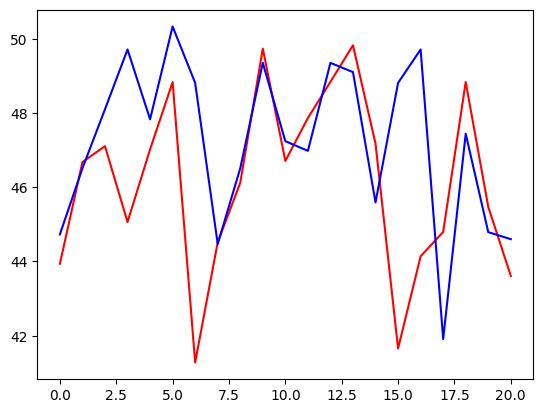

In [54]:
plt.plot(preds, color = "red")
plt.plot(y_test[:, IDX], color = "blue")
plt.show()

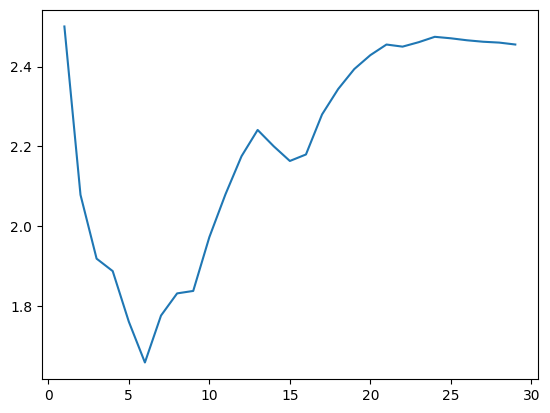

In [55]:
rmse_scores = cv_search.cv_results_['mean_test_score']
plt.plot([i for i in range(1, 30)], np.abs(rmse_scores))
plt.show()
plt.close()

In [ ]:
experiment = mlflow.set_experiment('IBF_NIR_ADF')
mlflow.set_tracking_uri('http://127.0.0.1:5000/')

In [ ]:
with mlflow.start_run():
    mlflow.log_params(parameters)
    mlflow.log_metrics(
        {
            'rmse': cv_search.best_score_
        }
    )

In [ ]:
cv_search.best_score_

In [ ]:
results = pl.dataframe.DataFrame(cv_search.cv_results_)

# Get params we care about
results = results[['params', 'mean_test_score', 'std_test_score']]

# convert to array for iterating
# results = results.to_numpy()
print(results)

# Loop through each experiment result and save the results to a
# nested experiement within the experiment
for row in results.rows():
    with mlflow.start_run():
        # Log model configuration/params
        mlflow.log_params(
            row[0]
        )
        # Log metrics
        metrics = {
            'rmse': row[1],
            'std': row[2]
            }
        mlflow.log_metrics(metrics)
        mlflow.sklearn.log_model(
    mlflow.end_run()

In [ ]:
cv_search.cv_results_


In [ ]:
cv_search.best_estimator_